### To create a csv file by taking the signal data

In [ ]:
import csv
from pyOpenBCI import OpenBCICyton
from datetime import datetime


# Function to print and save raw data
def print_raw_and_save(sample, csv_writer):
    timestamp = datetime.now().strftime("%H:%M:%S.%f")
    sample_data = [timestamp] + sample.channels_data
    print(sample_data)
    csv_writer.writerow(sample_data)

# Define the CSV file name
csv_file = "person1.csv"

# Open the CSV file in write mode
with open(csv_file, "w", newline="") as file:
    csv_writer = csv.writer(file)

    # Write a header row with column names if needed
    # csv_writer.writerow(["Timestamp", "Column1", "Column2", "Column3", ...])

    board = OpenBCICyton(port='COM4', daisy=False)

    try:
        board.start_stream(lambda sample: print_raw_and_save(sample, csv_writer))
    except KeyboardInterrupt:
        board.stop_stream()
        
print(f"Data saved to {csv_file}")

### To plot the signal with filters

C:\Users\Ihara Jithmini\AppData\Local\Temp\ipykernel_24952\2356790852.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Column5'] = subset['Column5'] * SCALE_FACTOR
C:\Users\Ihara Jithmini\AppData\Local\Temp\ipykernel_24952\2356790852.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['Column5'] = signal.lfilter(b, a, subset['Column5'])
C:\Users\Ihara Jithmini\AppData\Local\Temp\ipykernel_24952\2356790852.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

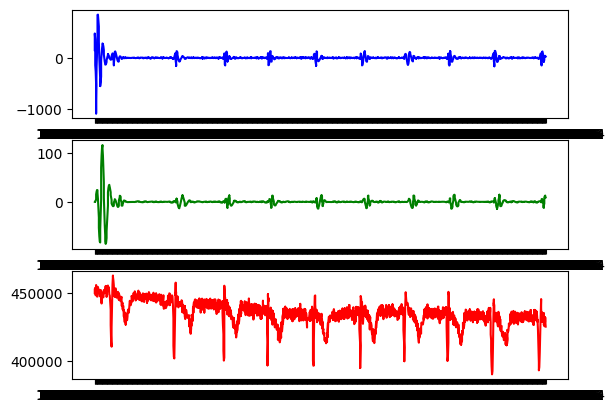

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal

# Load the CSV file into a DataFrame
csv_file = "person1.csv"

# Define column labels for the numerical columns
column_labels = ["Time", "Column1", "Column2", "Column3", "Column4", "Column5", "Column6", "Column7", "Column8"]

# Read the CSV file, specifying the first column as the index and providing the column labels
df = pd.read_csv(csv_file, index_col=0, header=None, names=column_labels)

# Now 'df' contains the data from the CSV file as a DataFrame

# Define the range you want to plot
start_index = "10:43:40.443830"  # Starting row index
end_index = "10:43:48.435804"  # Ending row index

# Select the subset of data for the specified range
subset = df.loc[start_index:end_index]
df_sub = df.loc[start_index:end_index]
# Define the SCALE_FACTOR
SCALE_FACTOR = (4500000) / 24 / (2**23 - 1)  # From the pyOpenBCI repo

# Apply the SCALE_FACTOR to 'Column5'
subset['Column5'] = subset['Column5'] * SCALE_FACTOR

t_data = np.array(subset['Column5']).T  # transpose data
fs = 250  # Hz

f0 = 50.0  # The notch frequency
Q = 0.5  # The quality factor by varying Q we can reduce the noise between 2 pulses

w0 = f0 / (fs / 2)  # Normalize the frequency
b, a = signal.iirnotch(w0, Q)
subset['Column5'] = signal.lfilter(b, a, subset['Column5'])

# Bandpass filter parameters
start_freq = 15.0  # Lower cutoff frequency
stop_freq = 80.0  # Upper cutoff frequency

# Design the bandpass filter
bp_Hz = np.array([start_freq, stop_freq])
b, a = signal.butter(5, bp_Hz / (fs / 2.0), btype='bandpass')

# Apply the bandpass filter to 'Column5'
subset['Column5'] = signal.lfilter(b, a, subset['Column5'])

# Low-pass filter parameters
low_pass_freq = 10.0  # Cutoff frequency for the low-pass filter

# Design the low-pass filter
lp_Hz = low_pass_freq
blp, alp = signal.butter(5, lp_Hz / (fs / 2.0), btype='lowpass')

# Apply the low-pass filter to 'Column5'
subset['LowPassFiltered'] = signal.lfilter(blp, alp, subset['Column5'])

fig = plt.figure(1)
plt.subplot(3, 1, 1)
plt.plot(subset.index, subset['Column5'], label='Filtered Column5', color='b')
plt.subplot(3, 1, 2)
plt.plot(subset.index, subset['LowPassFiltered'], label='Low-Pass Filtered Column5', color='g')
plt.subplot(3, 1, 3)
plt.plot(df_sub.index, df_sub['Column5'], label='Data Points', color='r')
plt.show()